# REINFORCE
This notebook shows one the most basic RL algorithms - [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf).  

It was tested on the `CartPole-v1` only.

In [1]:
import sys
from typing import Tuple

import gym
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F


sys.path.append("../")

from push_ups import agent_base
from push_ups.utils import default_network, training_loop

## Define Policy and the Agent
Policy can be some ML model which takes decisions based on the environment state (or the observation if the state is hidden).  
Agent defines how:
1. policy is created (`get_policy` method)
2. action are taken (`take_action` method)
3. policy is updated (`update_policy` method)

In [9]:
class PolicyAgent(agent_base.Agent):
    def __init__(self, env: gym.core.Env, gamma: float = 0.9, lr=0.003, *args, **kwargs):
        """
        :param: gamma: discount factor used to calculate return
        :param: lr: learning rate used in the torch optimizer
        """
        super().__init__(env, gamma, lr, *args, **kwargs)
        self.observations = []
        self.log_action_probabilities = []
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.return_mean = None
        self.return_std = None

    def take_action(self, observation: np.array, *args, **kwargs):
        del args, kwargs  # unused
        if not self.discrete_actions:
            raise NotImplementedError

        observation = torch.from_numpy(observation).float().unsqueeze(0)
        probabilities = self.policy(observation)

        m = Categorical(probabilities)
        action = m.sample()
        log_prob = m.log_prob(action)
        self.log_action_probabilities.append(log_prob)

        return action.item()

    def get_policy(self) -> nn.Module:
        inputs_no = self.get_observations()
        outputs_no = self.get_actions()
        discrete_outputs = self.discrete_actions
        return default_network.Policy(inputs_no, outputs_no, discrete_outputs)
    
    def update_return_mean_std(self, returns: torch.tensor):
        if self.return_mean is None:
            self.return_mean = returns.mean()
            self.return_std = returns.std()
        else:
            self.return_mean = returns.mean() * 0.05 + 0.95 * self.return_mean
            self.return_std = returns.std() * 0.05 + 0.95 * self.return_std
        
        

    def update_policy(self, rewards: torch.tensor, *args, **kwargs):
        del args, kwargs  # unused

        eps = np.finfo(np.float32).eps.item()

        returns = self.calculate_returns(rewards)
        self.update_return_mean_std(returns)
#         returns = (returns - self.return_mean) / (self.return_std + eps)                      # normalization with running mean and std
#         returns = (returns - returns.mean()) / (returns.std() + eps)                          # normalization

        policy_loss = []
        for log_prob, R in zip(self.log_action_probabilities, returns):
            policy_loss.append(-log_prob * R)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        del self.log_action_probabilities[:]

    def calculate_returns(self, rewards: torch.tensor) -> torch.tensor:
        returns = torch.flip(rewards, [0])
        for idx, item in enumerate(returns):
            if idx == 0:
                continue
            returns[idx] = item + self.gamma * returns[idx - 1]
        return torch.flip(returns, [0])

## Define the environmnet and the agent

In [10]:
env = gym.make("CartPole-v1")
agent = PolicyAgent(env, gamma=0.9, lr=0.01)

## Run training

In [11]:
episode_rewards_dict = {} 
running_rewards_dict = {}

for t in range(10):
    print(t)
    agent = PolicyAgent(env, gamma=0.9, lr=0.01)
    running_reward = None
    episode_rewards = []
    running_rewards = []


    for i_episode in range(4000):
        agent, rewards = training_loop.run_episode(agent, env)
        ep_reward = rewards.sum().item()

        if running_reward is None:
            running_reward = ep_reward
        else:
            running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        episode_rewards.append(ep_reward)
        running_rewards.append(running_reward)

        if running_reward > env.spec.reward_threshold:
            break

        agent.update_policy(rewards)
        
    episode_rewards_dict[t] = episode_rewards
    running_rewards_dict[t] = running_rewards

    

0
1
2
3
4
5
6
7
8
9


In [12]:
import pickle
res = [episode_rewards_dict, running_rewards_dict]
with open('REINFORCE_with_normalization.pickle', 'wb') as handle:
    pickle.dump(res, handle)
    
# with open('REINFORCE_no_normalization.pickle', 'rb') as handle:
#     episode_rewards_dict, running_rewards_dict = pickle.load(handle)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def setup_plot(ax):
    ax.set_xlim(0, 4000)
    ax.set_ylim(0, 500)
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Score')

    ax.legend()


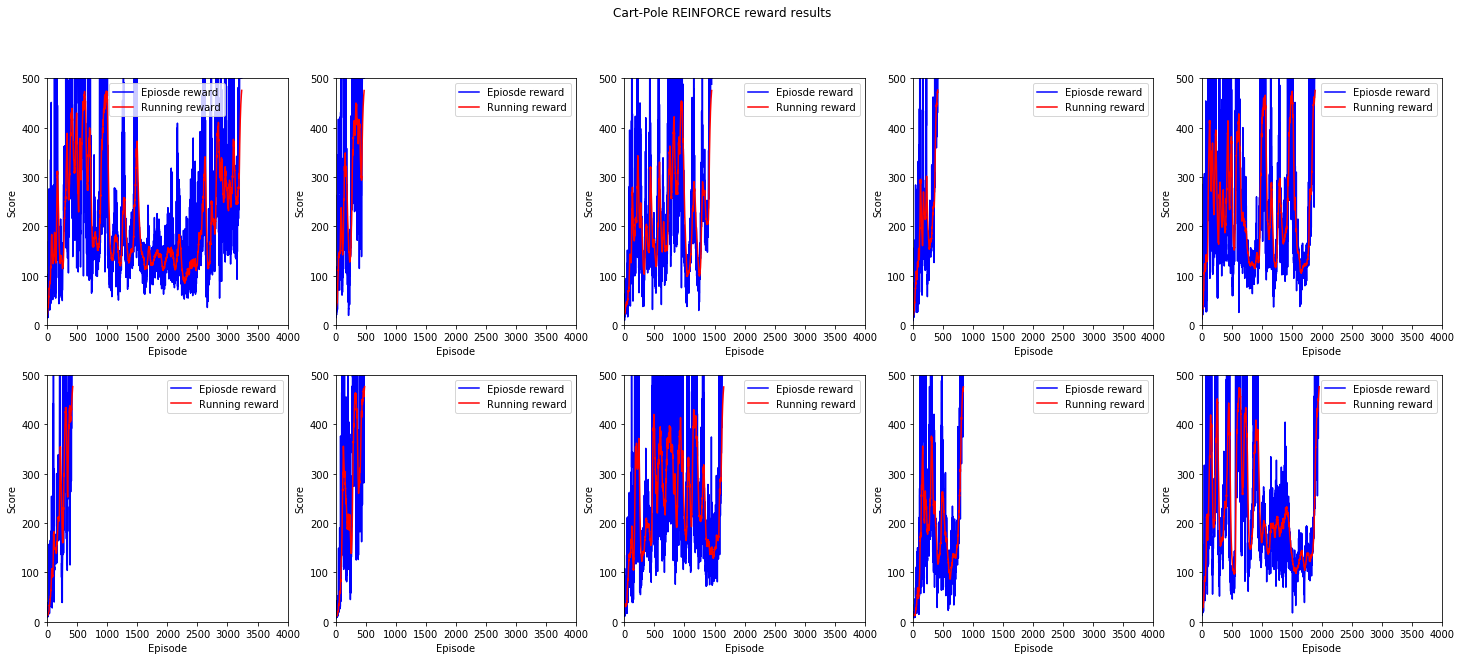

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Cart-Pole REINFORCE reward results")
for y in range(2):
    for x in range(5):
        
        sample = y * 5 + x

        x_epiosde_reward = range(len(episode_rewards_dict[sample]))
        y_epiosde_reward = episode_rewards_dict[sample]

        x_running_reward = range(len(running_rewards_dict[sample]))
        y_running_reward = running_rewards_dict[sample]

        axs[y][x].plot(x_epiosde_reward, y_epiosde_reward, 'b', label="Epiosde reward")
        axs[y][x].plot(x_running_reward, y_running_reward, 'r', label="Running reward")


        setup_plot(axs[y][x])

plt.show()

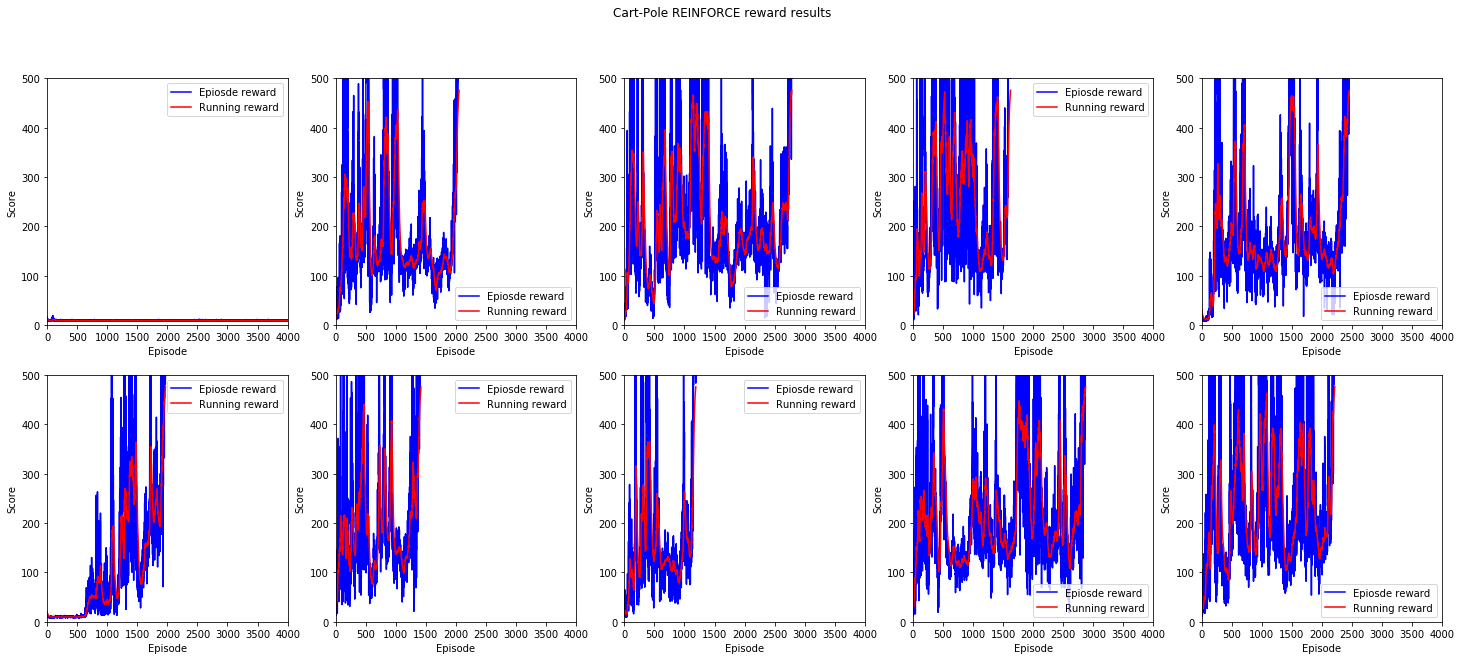

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Cart-Pole REINFORCE reward results")
for y in range(2):
    for x in range(5):
        
        sample = y * 5 + x

        x_epiosde_reward = range(len(episode_rewards_dict[sample]))
        y_epiosde_reward = episode_rewards_dict[sample]

        x_running_reward = range(len(running_rewards_dict[sample]))
        y_running_reward = running_rewards_dict[sample]

        axs[y][x].plot(x_epiosde_reward, y_epiosde_reward, 'b', label="Epiosde reward")
        axs[y][x].plot(x_running_reward, y_running_reward, 'r', label="Running reward")


        setup_plot(axs[y][x])

plt.show()

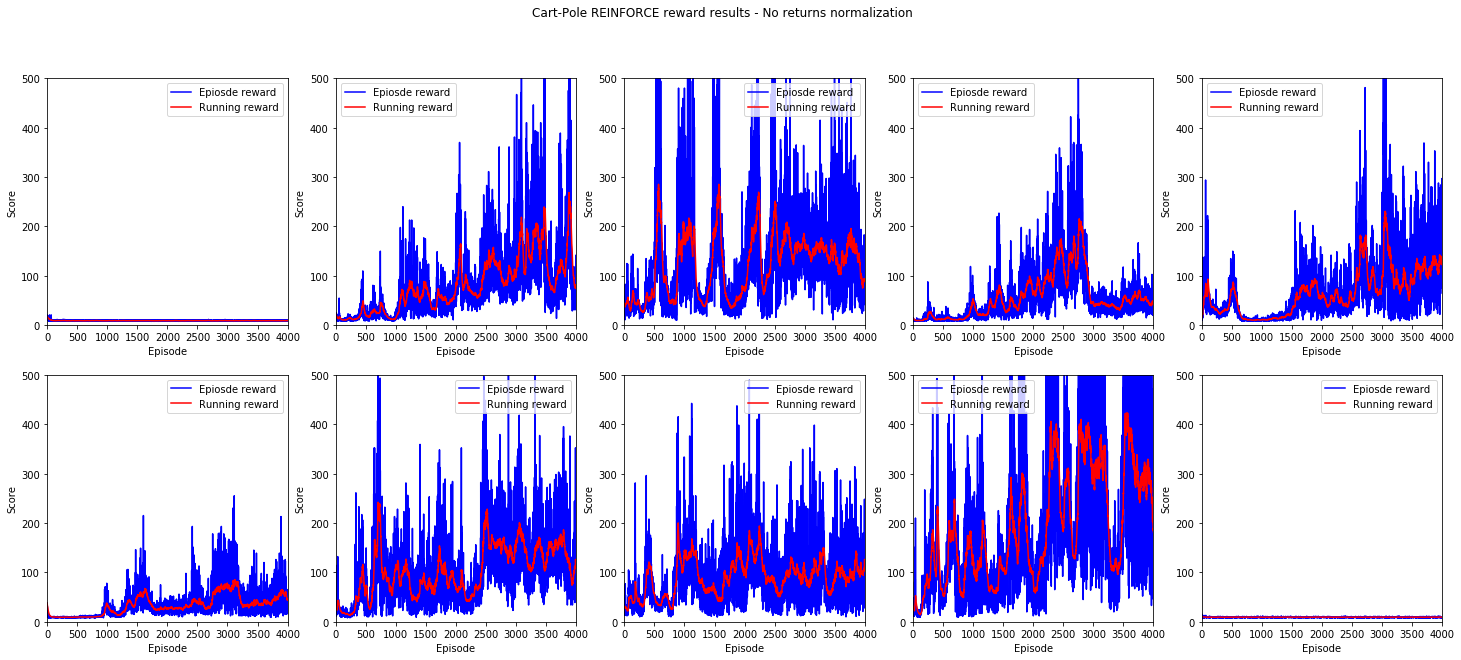

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Cart-Pole REINFORCE reward results - No returns normalization")
for y in range(2):
    for x in range(5):
        
        sample = y * 5 + x

        x_epiosde_reward = range(len(episode_rewards_dict[sample]))
        y_epiosde_reward = episode_rewards_dict[sample]

        x_running_reward = range(len(running_rewards_dict[sample]))
        y_running_reward = running_rewards_dict[sample]

        axs[y][x].plot(x_epiosde_reward, y_epiosde_reward, 'b', label="Epiosde reward")
        axs[y][x].plot(x_running_reward, y_running_reward, 'r', label="Running reward")


        setup_plot(axs[y][x])

plt.show()

## See the results

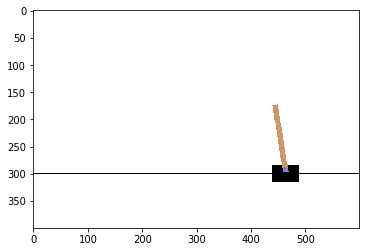

In [5]:
obs = env.reset()

img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for i in range(300):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action = agent(obs)
    obs, rew, done, info = env.step(action)
    
    if done:
        break